## Till now we saw that feature extraction and Fine tuning transfer learning has worked nicely, now we will try to implement same on food101 dataset of 10% training data with 101 food classes.

In [1]:
import os
Root = "/content/drive/MyDrive/Tensorflow certifications work"
!pwd
os.chdir(Root)
!pwd

/content
/content/drive/MyDrive/Tensorflow certifications work


## installing the helper functions file

In [2]:
try:
  if os.path.exists("Helper.py"):
    print("Helper file already exists..skipping download")
  else:
    !wget https://raw.githubusercontent.com/iamatul1214/Tensorflow_Certification_Preparation/main/Helper.py
    print("downloaded Helper.py")
except Exception as e:
  print(e)

Helper file already exists..skipping download


In [3]:
## Downloading the dataset
from Helper import unzip_data
try:
  if os.path.exists("101_food_classes_10_percent"):
    print("data already exists...hence, skipping downloading....")
  else:
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
    unzip_data("101_food_classes_10_percent.zip")
    print("unzipping the data")
except Exception as e:
  print(e)


data already exists...hence, skipping downloading....


In [4]:
## Setting up the data loaders
import tensorflow as tf
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"
IMG_SIZE = (224,224)

full_classes_10_percent_train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                         label_mode = 'categorical',
                                                                                         image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## train a big dog model with transfer learning on 10% of the 101 food classes

Here are the steps we will follow-
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build a data augmentation right into the moddel
* BUild a headless(no top layers) functional EfficientNetB0 backboned-model ( we will create our own output layer) 
* compile our model
* feature extract for 5 full passes( 5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [5]:
## creating a checkpoint callback
from Helper import create_tensorboard_callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         monitor = 'val_accuracy',
                                                         save_best_only = True,
                                                         save_weights_only = True)


In [6]:
## Data augmentation layer to incorporate right into the model
from tensorflow.keras.layers.experimental import preprocessing

## setup data augmentation
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1/255.). ## not required for efficientNetB0 but for resnet50
], name = "Data_augmentataiton_layer")


In [7]:
## Setup the base model and freeze its layers ( this will extract the features )
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

## Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape = (224,224,3), name = "input_layer")
x = data_augmentation(inputs) #augment images( only happens during training phase)
x = base_model(x, training = False) # put the base model in inference mode so weights which need to stay frozen will remian frozen
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_avg_pool_layer")(x)
outputs = tf.keras.layers.Dense(len(full_classes_10_percent_train_data.class_names), activation="softmax", name = "output_layer")(x)
model = tf.keras.Model(inputs,outputs)


16705208/16705208 [==============================] - 1s 0us/step


In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Data_augmentataiton_layer (  (None, 224, 224, 3)      0         
 Sequential)                                                     
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [9]:
## compiling the model
model.compile(loss = tf.keras.losses.categorical_crossentropy,
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

In [12]:
## Training the model for 5 epochs
history_all_classes_10_percent = model.fit(full_classes_10_percent_train_data,epochs = 5, 
         steps_per_epoch = len(full_classes_10_percent_train_data),
          validation_data = test_data,
          validation_steps = int(0.5 * len(test_data)),
          callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 85s 355ms/step - loss: 1.3245 - accuracy: 0.6742 - val_loss: 1.6161 - val_accuracy: 0.5780
Epoch 2/5
237/237 [==============================] - 83s 347ms/step - loss: 1.2300 - accuracy: 0.6981 - val_loss: 1.6057 - val_accuracy: 0.5791
Epoch 3/5
237/237 [==============================] - 82s 343ms/step - loss: 1.1496 - accuracy: 0.7213 - val_loss: 1.5992 - val_accuracy: 0.5772
Epoch 4/5
237/237 [==============================] - 82s 342ms/step - loss: 1.0788 - accuracy: 0.7356 - val_loss: 1.5857 - val_accuracy: 0.5848
Epoch 5/5
237/237 [==============================] - 78s 328ms/step - loss: 1.0175 - accuracy: 0.7455 - val_loss: 1.5909 - val_accuracy: 0.5820


In [13]:
## Evaluate on whole test dataset
model.evaluate(test_data)

790/790 [==============================] - 82s 104ms/step - loss: 1.5145 - accuracy: 0.5954


[1.5145255327224731, 0.5954059362411499]

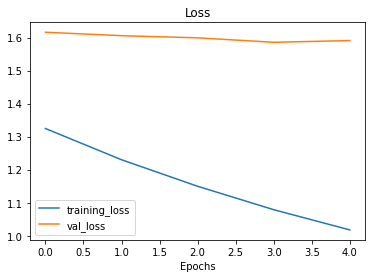

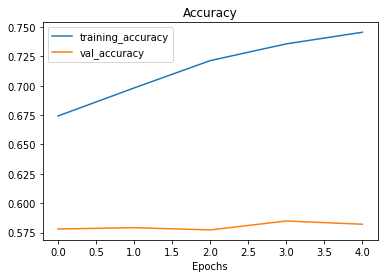

In [14]:
from Helper import plot_loss_curves
plot_loss_curves(history_all_classes_10_percent)

## Fine Tuning

In [26]:
## Unfreeze all the layers in the base model
base_model.trainable = True

## Refreeze every layer except last 5
for layer in base_model.layers[:-5]:
  layer.trainable = True



## Recompile model with lower learning rate (it's typically best practice to lower the learning rate during finetuning

In [27]:
model.compile(loss = tf.keras.losses.categorical_crossentropy,
              optimizer = tf.keras.optimizers.Adam(lr = 0.0001),  #learning rate lowered by 10x
              metrics = ['accuracy'])
 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [28]:
## What layers in the model are trainable ?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
Data_augmentataiton_layer True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [30]:
## check which layers are trainable in our base_model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 True
1 rescaling True
2 normalization True
3 tf.math.truediv True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block2a_expand_conv True
19 block2a_expand_bn True
20 block2a_expand_activation True
21 block2a_dwconv_pad True
22 block2a_dwconv True
23 block2a_bn True
24 block2a_activation True
25 block2a_se_squeeze True
26 block2a_se_reshape True
27 block2a_se_reduce True
28 block2a_se_expand True
29 block2a_se_excite True
30 block2a_project_conv True
31 block2a_project_bn True
32 block2b_expand_conv True
33 block2b_expand_bn True
34 block2b_expand_activation True
35 block2b_dwconv True
36 block2b_bn True
37 block2b_activation True
38 block2b_se_squeeze True
39 block2b_se_reshape True
40 block2b